In [1]:
!pip install textstat

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [2]:
!pip install spacy

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [3]:
!pip install palettable

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [4]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from palettable.colorbrewer.qualitative import Pastel1_7, Dark2_7, Set3_5

import nltk
#from transformers import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import defaultdict

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output

# Import Train and Test Data

In [5]:
train = pd.read_csv("C:\\Users\\Stokes\\Documents\\DS Princ Final Project\\train.csv")
test = pd.read_csv("C:\\Users\\Stokes\\Documents\\DS Princ Final Project\\test.csv")

In [6]:
train

textID                                               text  \
0      cb774db0d1                I`d have responded, if I were going   
1      549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2      088c60f138                          my boss is bullying me...   
3      9642c003ef                     what interview! leave me alone   
4      358bd9e861   Sons of ****, why couldn`t they put them on t...   
...           ...                                                ...   
27476  4eac33d1c0   wish we could come see u on Denver  husband l...   
27477  4f4c4fc327   I`ve wondered about rake to.  The client has ...   
27478  f67aae2310   Yay good for both of you. Enjoy the break - y...   
27479  ed167662a5                         But it was worth it  ****.   
27480  6f7127d9d7     All this flirting going on - The ATG smiles...   

                                           selected_text sentiment  
0                    I`d have responded, if I were going   neutral  
1                                               Sooo SAD  negative  
2                                            bullying me  negative  
3                                         leave me alone  negative  
4                                          Sons of ****,  negative  
...                                                  ...       ...  
27476                                             d lost  negative  
27477                                      , don`t force  negative  
27478                          Yay good for both of you.  positive  
27479                         But it was worth it  ****.  positive  
27480  All this flirting going on - The ATG smiles. Y...   neutral  

[27481 rows x 4 columns]

In [7]:
test

textID                                               text sentiment
0     f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral
1     96d74cb729   Shanghai is also really exciting (precisely -...  positive
2     eee518ae67  Recession hit Veronique Branquinho, she has to...  negative
3     01082688c6                                        happy bday!  positive
4     33987a8ee5             http://twitpic.com/4w75p - I like it!!  positive
...          ...                                                ...       ...
3529  e5f0e6ef4b  its at 3 am, im very tired but i can`t sleep  ...  negative
3530  416863ce47  All alone in this old house again.  Thanks for...  positive
3531  6332da480c   I know what you mean. My little dog is sinkin...  negative
3532  df1baec676  _sutra what is your next youtube video gonna b...  positive
3533  469e15c5a8   http://twitpic.com/4woj2 - omgssh  ang cute n...  positive

[3534 rows x 3 columns]

# Exploratory Data Analysis

Based on above, we have 27481 Tweets in the training data and 3535 tweets in the test data

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
textID           27481 non-null object
text             27480 non-null object
selected_text    27480 non-null object
sentiment        27481 non-null object
dtypes: object(4)
memory usage: 858.9+ KB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
textID       3534 non-null object
text         3534 non-null object
sentiment    3534 non-null object
dtypes: object(3)
memory usage: 83.0+ KB


In [10]:
# Remove Null value in Train
train.dropna(inplace=True)

In [11]:
train.describe()

textID                                               text  \
count        27480                                              27480   
unique       27480                                              27480   
top     72b3655419  Catching up on 2 weeks of LOST and Grey`s!!   ...   
freq             1                                                  1   

       selected_text sentiment  
count          27480     27480  
unique         22463         3  
top             good   neutral  
freq             199     11117

In [12]:
test.describe()

textID                                               text  \
count         3534                                               3534   
unique        3534                                               3534   
top     1dc7f3d536  about to take my mum out for jewellery shoppin...   
freq             1                                                  1   

       sentiment  
count       3534  
unique         3  
top      neutral  
freq        1430

## All Data Sentiment Distributions

In [13]:
temp_train = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp_test = test.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp = temp_train
temp['text'] = temp_train['text'] + temp_test['text']
temp.style.background_gradient(cmap='Blues')

In [14]:
fig = go.Figure(go.Funnelarea(
    text = temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

Clearly there are a majority of neutral tweets

## Meta-Features for Text Prediction

Since we are trying to predict a subset of text, it would be useful to extract the following:

1. Number of words in selected text
2. Number of words in main text
3. Difference of words between main and selected text
4. Jaccard similarity scores between text and selected text

Notes on Jaccard: https://www.geeksforgeeks.org/find-the-jaccard-index-and-jaccard-distance-between-the-two-given-sets/

In [15]:
# Jaccard Function
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [16]:
# Fill Jaccard Array
results_jaccard=[]

for ind,row in train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text
    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])
    
results_jaccard[0]

[' I`d have responded, if I were going',
 'I`d have responded, if I were going',
 1.0]

In [17]:
# Make train contain Number of words in selected text, number of words, and difference in words
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train = train.merge(jaccard,how='outer')
train['num_words_st'] = train['selected_text'].apply(lambda x:len(str(x).split())) 
train['num_words_t'] = train['text'].apply(lambda x:len(str(x).split())) 
train['words_difference'] = train['num_words_t'] - train['num_words_st']

train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  jaccard_score  num_words_st  \
0  I`d have responded, if I were going   neutral       1.000000             7   
1                             Sooo SAD  negative       0.200000             2   
2                          bullying me  negative       0.166667             2   
3                       leave me alone  negative       0.600000             3   
4                        Sons of ****,  negative       0.214286             3   

   num_words_t  words_difference  
0            7                 0  
1           10                 8  
2            5                 3  
3            5                 2  
4           14                11

Now, we will highlight the distribution of the new meta-features

In [18]:
hist_data = [train['num_words_st'],train['num_words_t']]

group_labels = ['Selected Text', 'Full Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number of Words - Percent of All Entries vs. Word Count')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

This graph highlights a few important discoveries:

1. 25% of all selected texts are 1 word
2. The selected text % (# entries with i selected text words / total entries) monotonically decreases as word count increases
3. Most tweets are between 4-12 words in full
4. Hardly any tweets go above 25 words

Now we will look at the difference of # of words and by sentiment

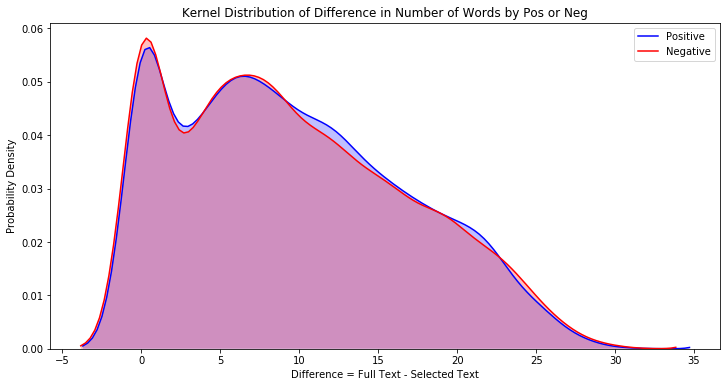

In [19]:
# Keep in mind that difference in number of words means (full text - selected text)
plt.figure(figsize=(12,6))
plt.xlabel("Difference = Full Text - Selected Text")
plt.ylabel("Probability Density")
p1=sns.kdeplot(train[train['sentiment']=='positive']['words_difference'], shade=True, color="b", label='Positive').set_title('Kernel Distribution of Difference in Number of Words by Pos or Neg')
p2=sns.kdeplot(train[train['sentiment']=='negative']['words_difference'], shade=True, color="r", label='Negative')

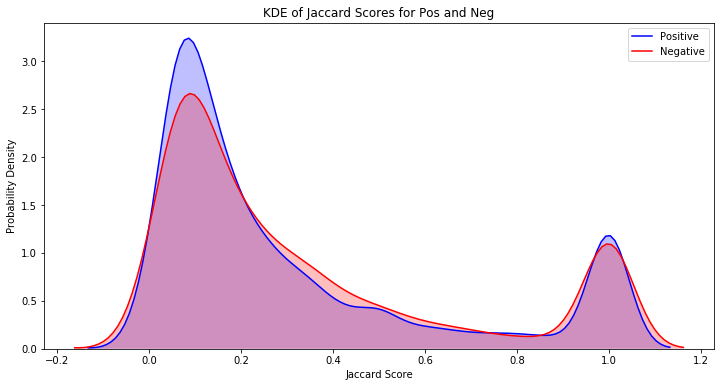

In [20]:
plt.figure(figsize=(12,6))
plt.xlabel("Jaccard Score")
plt.ylabel("Probability Density")
p1=sns.kdeplot(train[train['sentiment']=='positive']['jaccard_score'], shade=True, color="b").set_title('KDE of Jaccard Scores for Pos and Neg')
p2=sns.kdeplot(train[train['sentiment']=='negative']['jaccard_score'], shade=True, color="r")
plt.legend(labels=['Positive','Negative'])

Based on the graph above, the mathematical difference between the full text and the selected text count seems consistent whether or not the text is positive or negative. However, the jaccard score shows us that positive tweets are both more likely to be exactly the same as the selected text and more likely to have a small amount of similarity between the two (based on the two major curves above).

We also find that there is a shared peak around 1.0 jaccard score. This means that there is a high similarity between normal and selected texts here and we should try to find that.

Text(0.5, 1.0, 'Distribution of Difference in Number of Words for Neutral')

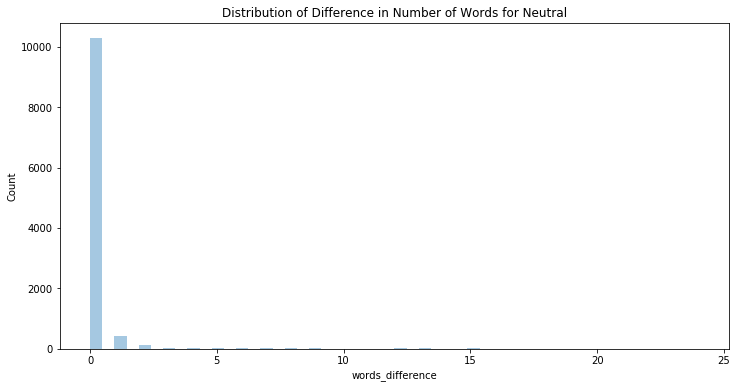

In [21]:
plt.figure(figsize=(12,6))
plt.ylabel("Count")
sns.distplot(train[train['sentiment']=='neutral']['words_difference'], kde=False).set_title('Distribution of Difference in Number of Words for Neutral')

Text(0.5, 1.0, 'Distribution of Jaccard Score for Neutral')

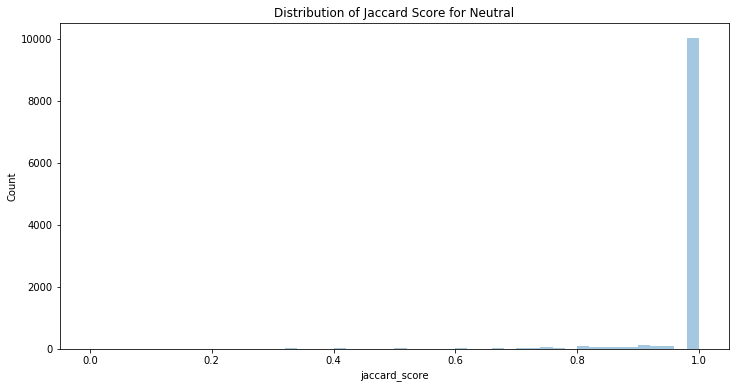

In [22]:
plt.figure(figsize=(12,6))
plt.xlabel("Jaccard Score")
plt.ylabel("Count")
sns.distplot(train[train['sentiment']=='neutral']['jaccard_score'],kde=False).set_title('Distribution of Jaccard Score for Neutral')

We can tell from the plot above that a vast majority of neutral tweets have the same full text and selected text. Thus, the KDE plot is ineffective and we use basic distribution plots.

## Simple Cleaning

In [23]:
# Makes text lowercase
# Removes text in square brackets
# Remove Links
# Remove punctuation
# Remove words containing numbers

#basic cleaning
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

In [24]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]

In [25]:
train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [26]:
train.head()

textID                                               text  \
0  cb774db0d1                  id have responded if i were going   
1  549e992a42         sooo sad i will miss you here in san diego   
2  088c60f138                             my boss is bullying me   
3  9642c003ef                      what interview leave me alone   
4  358bd9e861   sons of  why couldnt they put them on the rel...   

                       selected_text sentiment  jaccard_score  num_words_st  \
0  id have responded if i were going   neutral       1.000000             7   
1                           sooo sad  negative       0.200000             2   
2                        bullying me  negative       0.166667             2   
3                     leave me alone  negative       0.600000             3   
4                           sons of   negative       0.214286             3   

   num_words_t  words_difference  
0            7                 0  
1           10                 8  
2            5                 3  
3            5                 2  
4           14                11

# Word Frequencies

We will now analyze word frequencies by different groupings including selected text, full text, and sentiment.

## Word Frequency - Selected Text

In [27]:
train['sel_freq'] = train['selected_text'].apply(lambda x:str(x).split())
train['sel_freq'] = train['sel_freq'].apply(lambda x:remove_stopword(x))

In [28]:
top = Counter([item for sublist in train['sel_freq'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']

fig = px.bar(temp, x="count", y="Common_words", title='Common Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words in Selected Text')
fig.show()

## Word Frequency - Full Text

In [29]:
train['ful_freq'] = train['text'].apply(lambda x:str(x).split())
train['ful_freq'] = train['ful_freq'].apply(lambda x:remove_stopword(x))

In [30]:
top = Counter([item for sublist in train['ful_freq'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']

fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Full Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words in Full Text')
fig.show()

## Word Frequncy - Full Text by Sentiment

In [34]:
pos = train[train['sentiment']=='positive']
neg = train[train['sentiment']=='negative']
neu = train[train['sentiment']=='neutral']

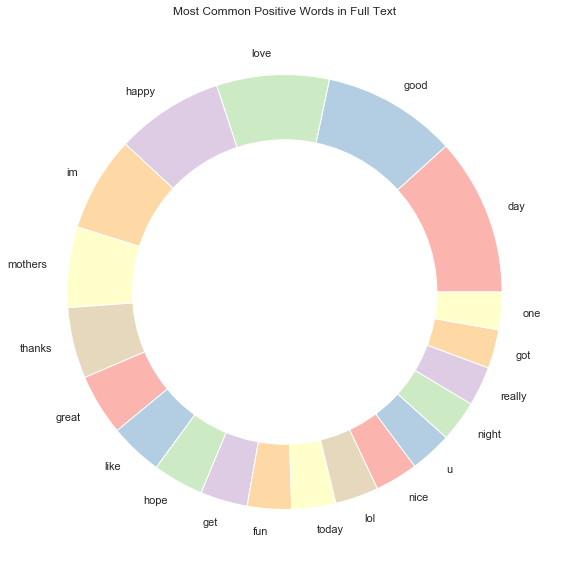

In [35]:
top = Counter([item for sublist in pos['ful_freq'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']

plt.figure(figsize=(16,10))
pos_circle = plt.Circle((0,0), 0.7, color='white')
plt.pie(temp_positive['count'], labels=temp_positive.Common_words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(pos_circle)
plt.title('Most Common Positive Words in Full Text')
plt.show()
temp_positive.style.background_gradient(cmap='Greens')

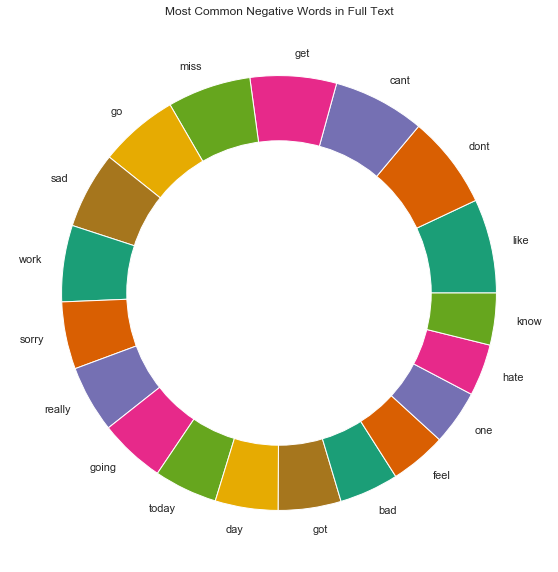

In [36]:
top = Counter([item for sublist in neg['ful_freq'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']

plt.figure(figsize=(16,10))
pos_circle = plt.Circle((0,0), 0.7, color='white')
plt.pie(temp_negative['count'], labels=temp_negative.Common_words, colors=Dark2_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(pos_circle)
plt.title('Most Common Negative Words in Full Text')
plt.show()

temp_negative.style.background_gradient(cmap='Reds')

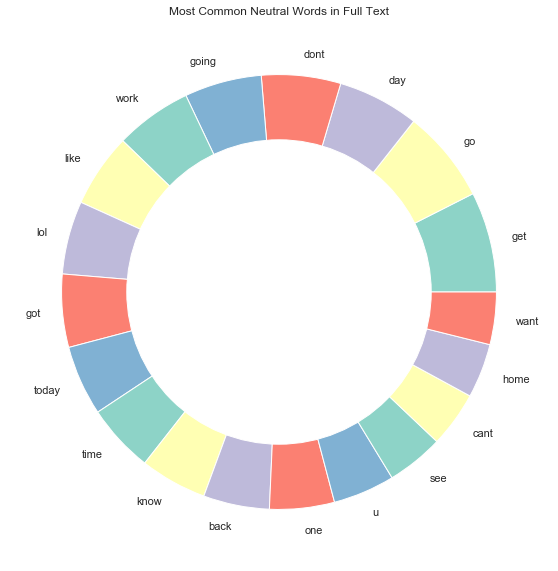

In [37]:
top = Counter([item for sublist in neu['ful_freq'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']

plt.figure(figsize=(16,10))
pos_circle = plt.Circle((0,0), 0.7, color='white')
plt.pie(temp_neutral['count'], labels=temp_neutral.Common_words, colors=Set3_5.hex_colors)
p=plt.gcf()
p.gca().add_artist(pos_circle)
plt.title('Most Common Neutral Words in Full Text')
plt.show()

temp_neutral.style.background_gradient(cmap='Blues')

# Word Clouds - Unique and Full Text by Sentiment

In [38]:
#Extract all words in train - full text NOT selected text
raw_words = [word for word_list in train['ful_freq'] for word in word_list]

In [41]:
#Input: Which Sentiment, how many words to analyze, list of all words
#Output: Unique Words (return # defined by numwords)

def get_unique_words(sentiment, numwords, raw_words):
    all_other = []
    for item in train[train.sentiment != sentiment]['ful_freq']:
        for word in item:
            all_other.append(word)
    all_other = list(set(all_other))
    
    specific_only = [x for x in raw_words if x not in all_other]
    
    counter = Counter()
    
    for item in train[train.sentiment == sentiment]['ful_freq']:
        for word in item:
            counter[word] += 1
    keep = list(specific_only)
    
    for word in list(counter):
        if word not in keep:
            del counter[word]
    
    unique_words = pd.DataFrame(counter.most_common(numwords), columns = ['words','count'])
    
    return unique_words

In [42]:
pos_unique = get_unique_words('positive', 15, raw_words)
neg_unique = get_unique_words('negative', 15, raw_words)
neu_unique = get_unique_words('neutral', 15, raw_words)

In [43]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    # Removed more fillers, places, non-real words, etc. for cloud readability
    more_stopwords = {'u', "im", "ive", "ur", "Length",
                      "dtype", "ma", "san", "diego", "atg",
                      "ju", "ta", "tha", "da", "rel", "denver", "gametrying",
                      "hahadid", "crythe", "muchi", "rec", "bh", "id", "la", "oz"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

In [44]:
mask = np.array(Image.open("C:\\Users\\Stokes\\Documents\\DS Princ Final Project\\wordcloud\\twitter_mask.png"))

In [45]:
def make_clouds(unique=False):
    if(unique):
        ne = neu_unique
        po = pos_unique
        ng = neg_unique
    else:
        ne = neu.text
        po = pos.text
        ng = neg.text
    return ne, po, ng

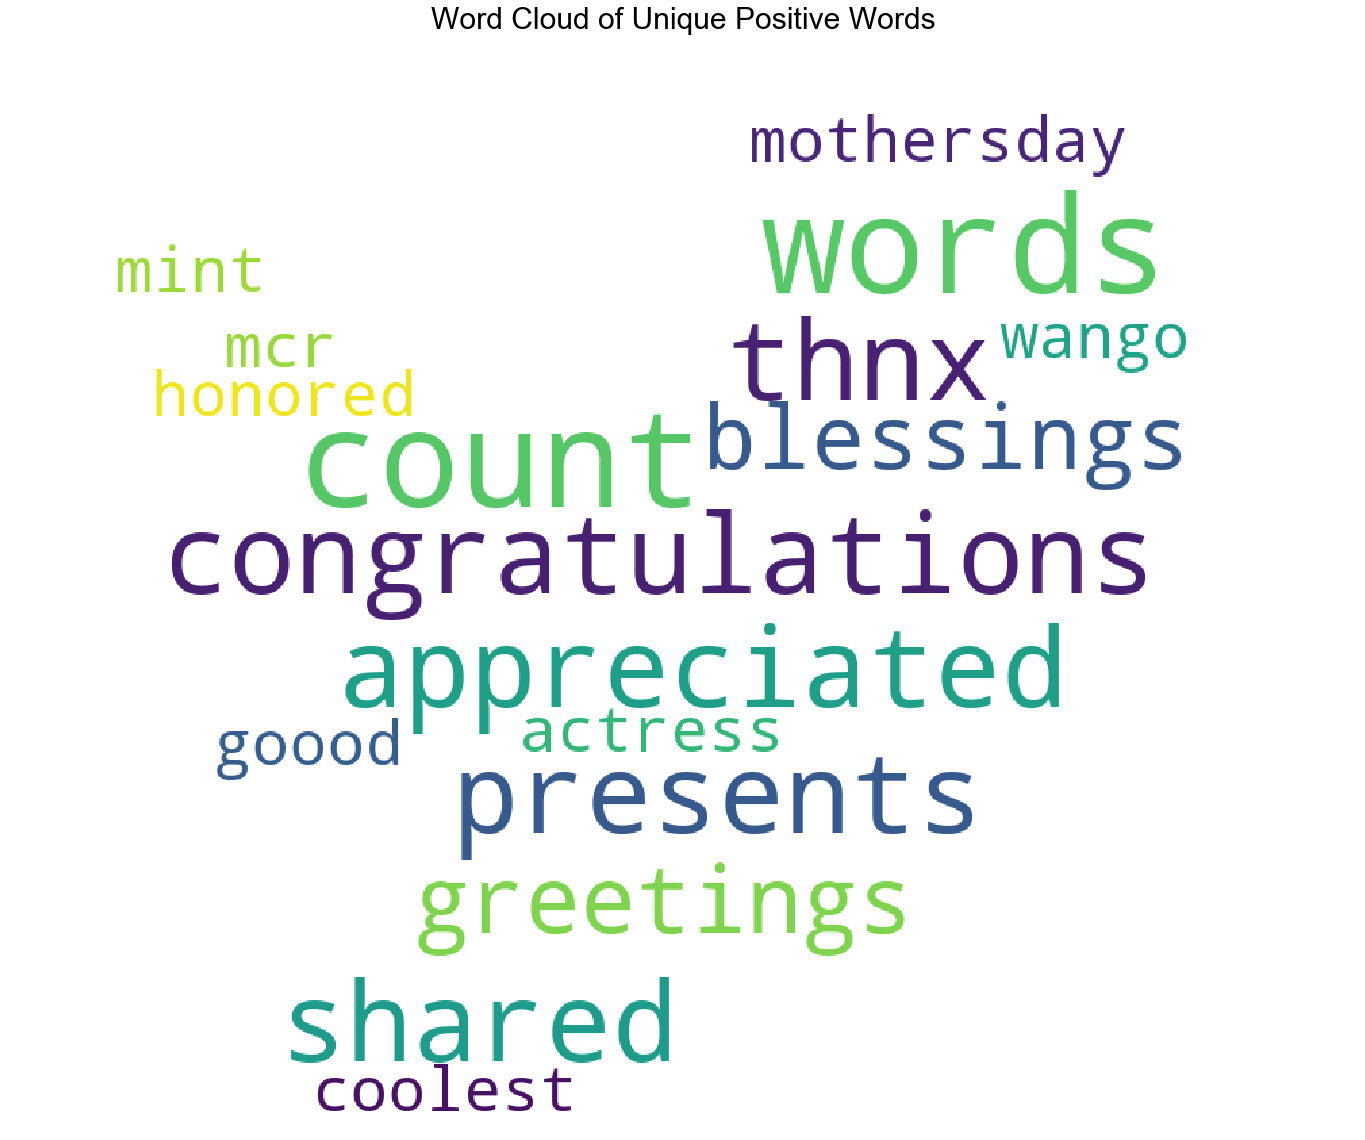

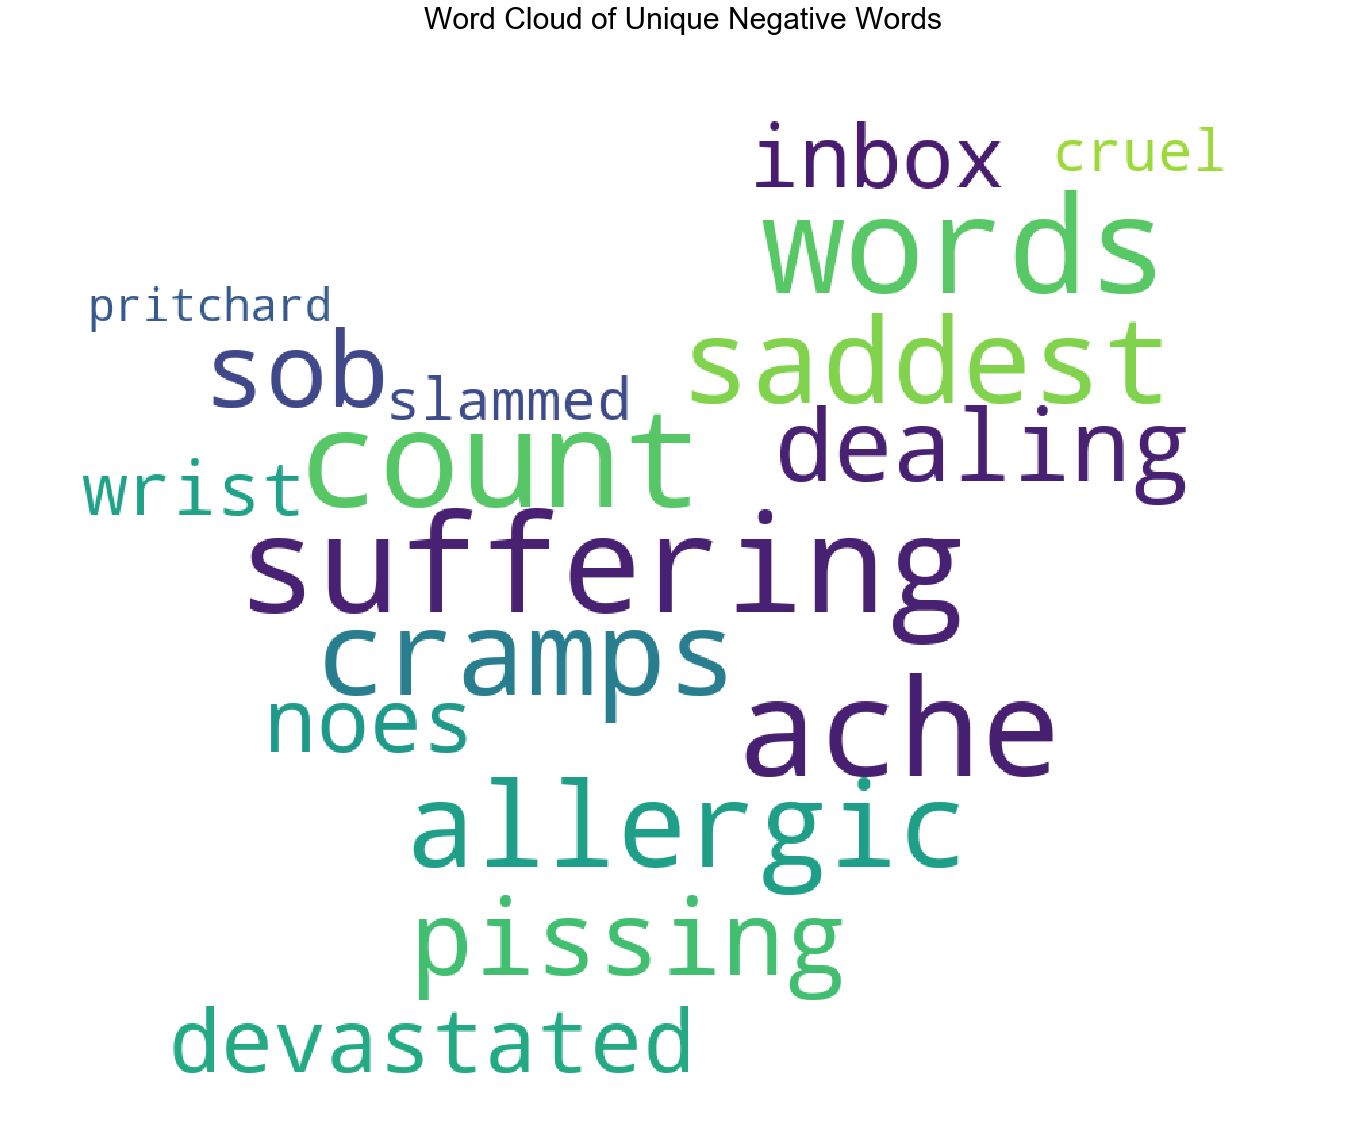

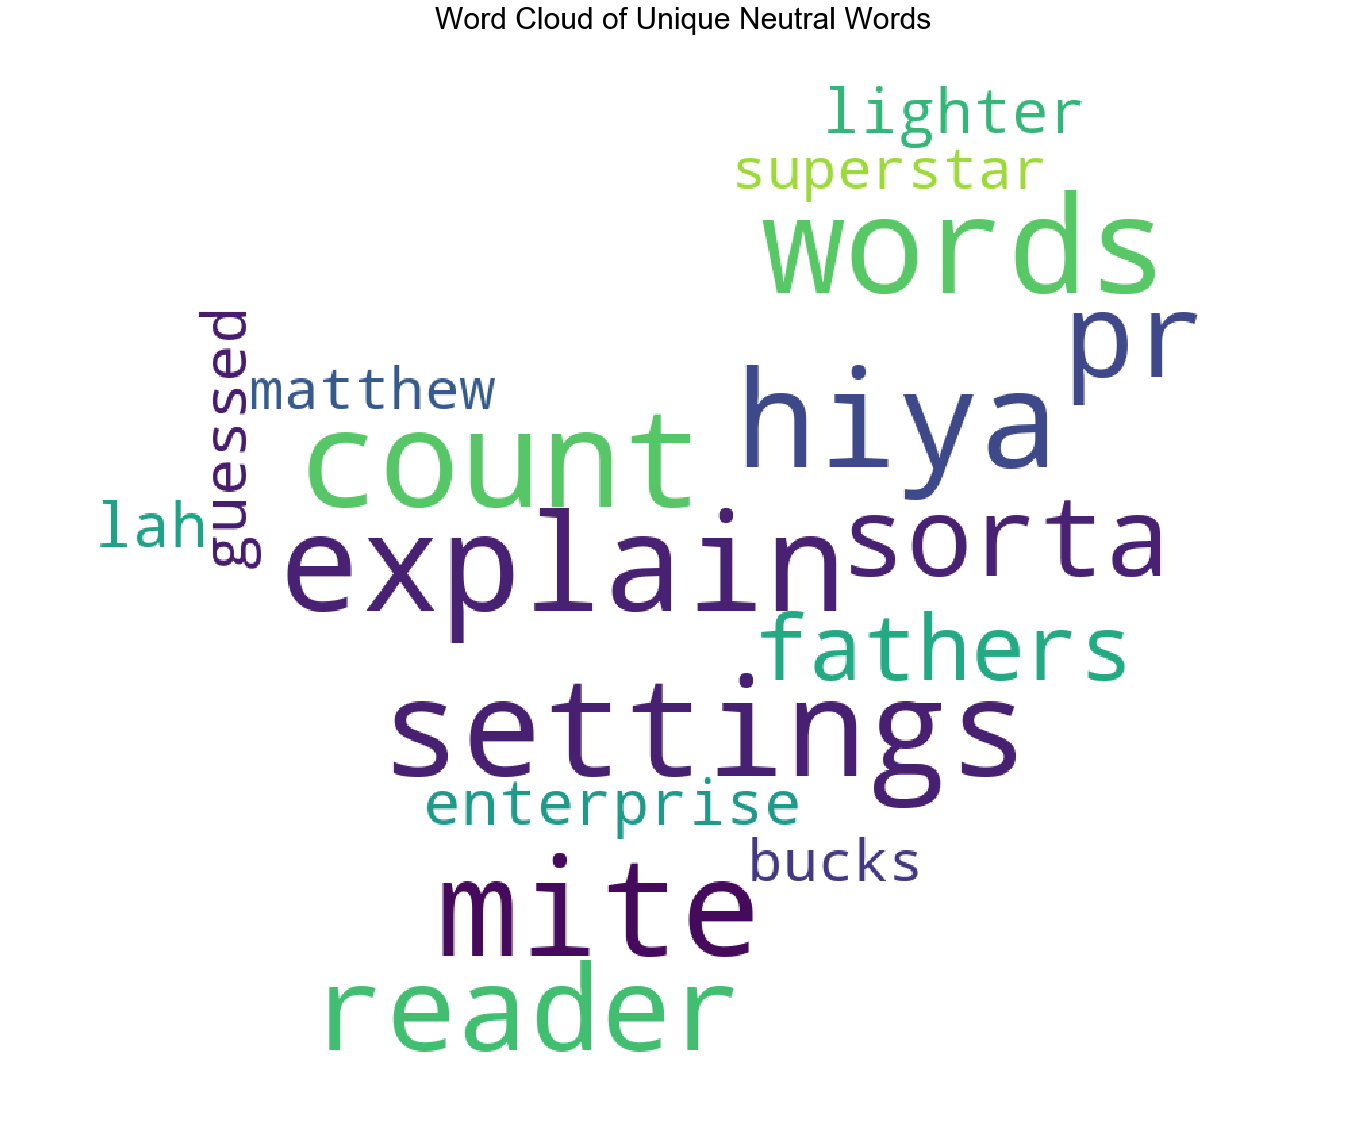

In [46]:
# Set argument into make_clouds as false for non unique words
ne, po, ng = make_clouds(unique=True)

plot_wordcloud(po, mask = mask,
               color='white', max_font_size=100,
               title_size=30,
               title="Word Cloud of Unique Positive Words")
plot_wordcloud(ng, mask = mask,
               color='white', max_font_size=100,
               title_size=30,
               title="Word Cloud of Unique Negative Words")
plot_wordcloud(ne, mask = mask,
               color='white', max_font_size=100,
               title_size=30,
               title="Word Cloud of Unique Neutral Words")

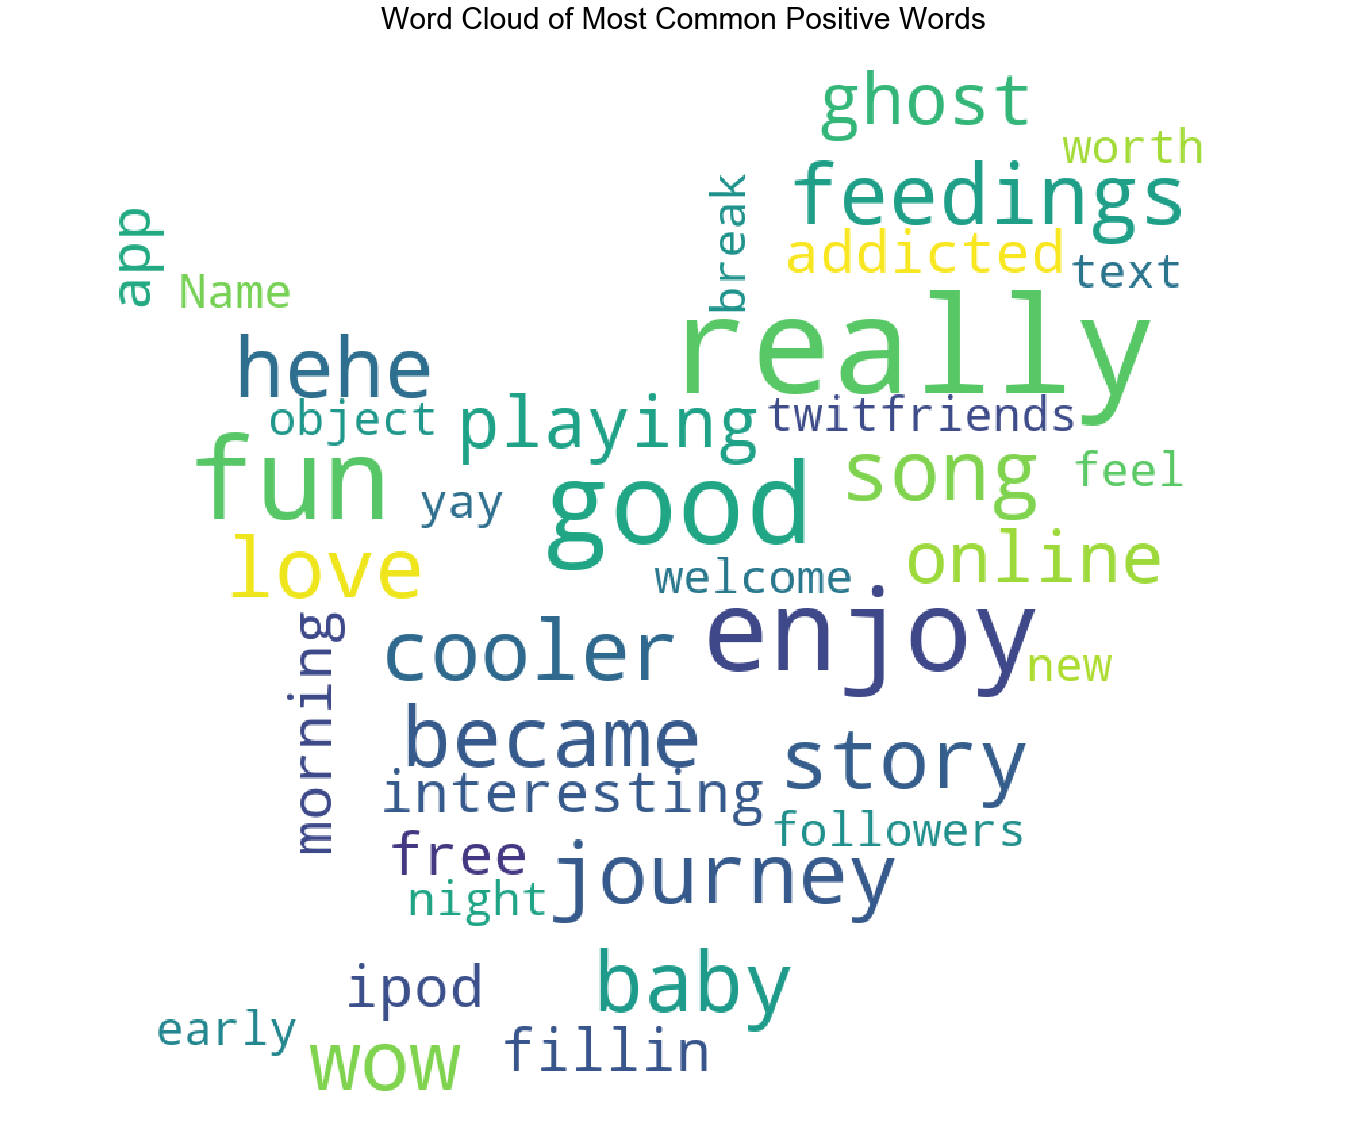

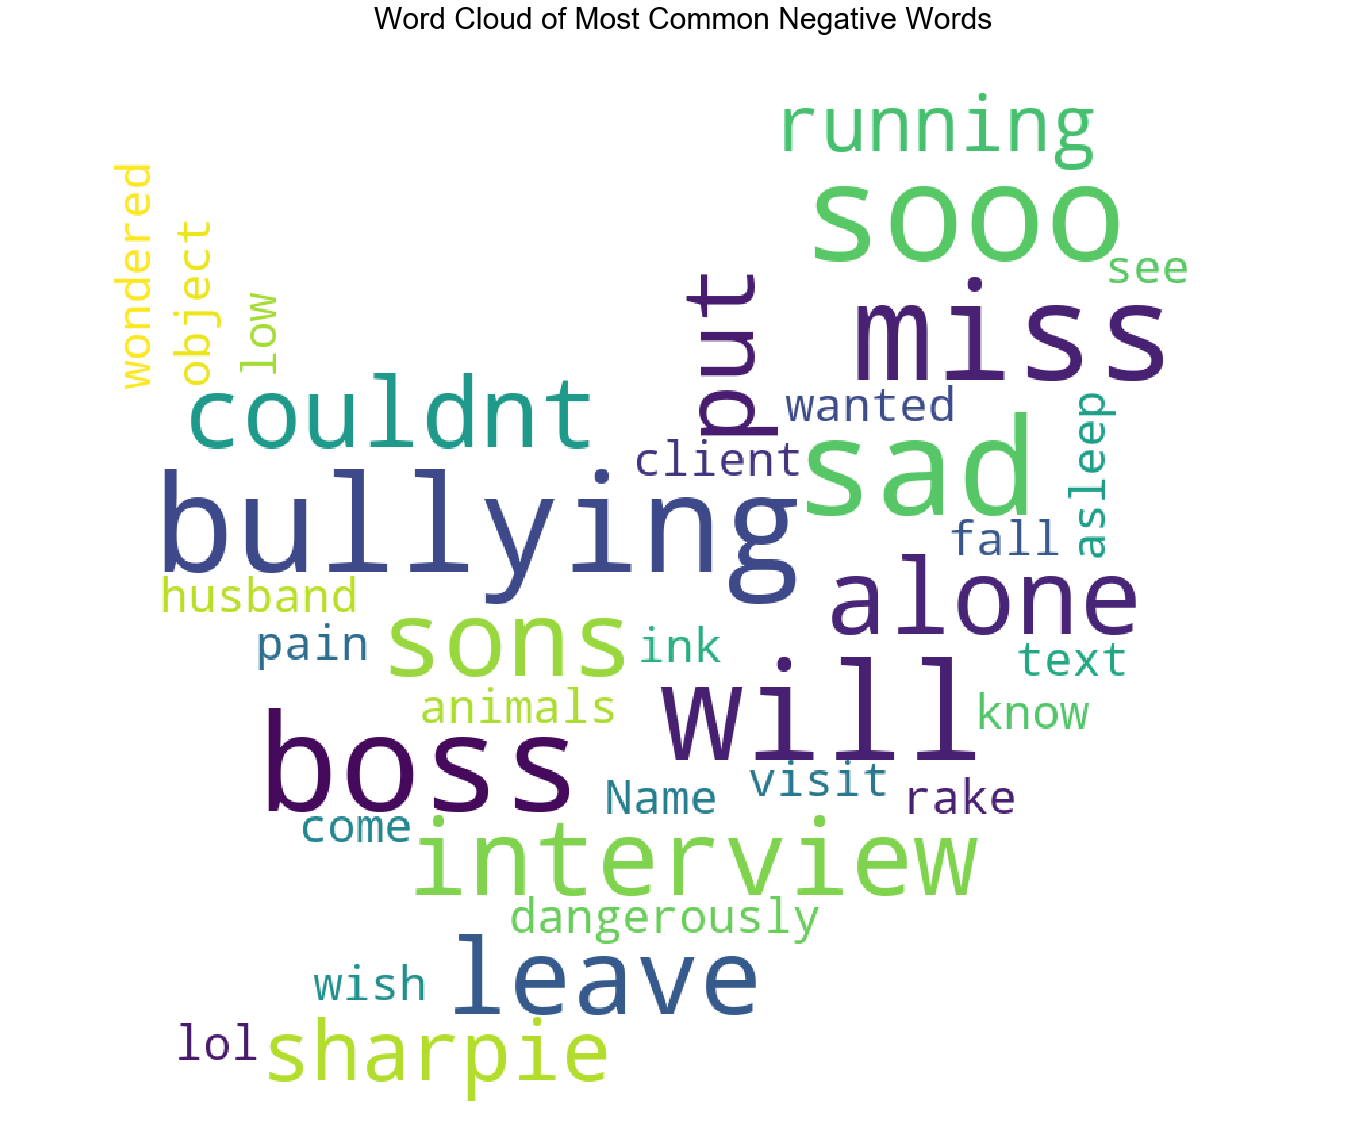

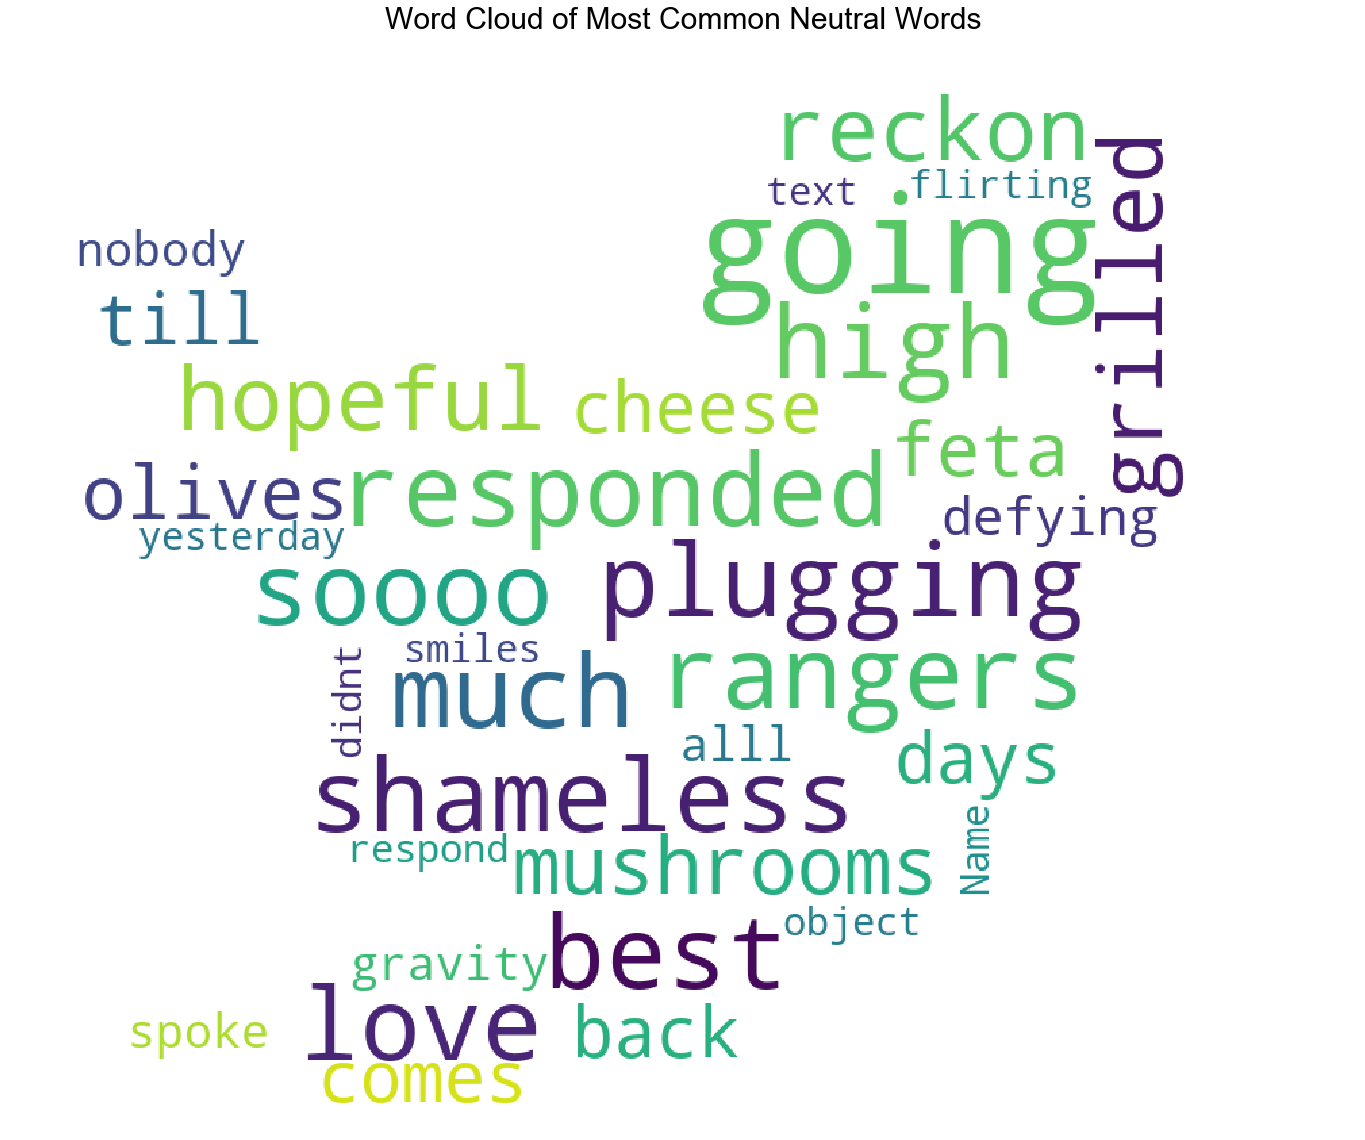

In [47]:
# Set argument into make_clouds as false for non unique words
ne, po, ng = make_clouds(unique=False)

plot_wordcloud(po, mask = mask,
               color='white', max_font_size=100,
               title_size=30,
               title="Word Cloud of Most Common Positive Words")
plot_wordcloud(ng, mask = mask,
               color='white', max_font_size=100,
               title_size=30,
               title="Word Cloud of Most Common Negative Words")
plot_wordcloud(ne, mask = mask,
               color='white', max_font_size=100,
               title_size=30,
               title="Word Cloud of Most Common Neutral Words")